# Convolutional Neural Networks

We will now build toward the next big idea in neural networks: convolutional neural networks (frequently called CNNs or ConvNets). These are nets that take some inspiration from the way neurons are connected in an animal's visual cortex, where different groups of neurons respond to specific portions of the visual field and then those signals are combined in a sort of hierarchy that is thought to allow animals to extract increasingly complex features within the incoming visual stimuli.

CNNs are are feedforward neural networks like we have seen, but neurons in one layer are not necessarily connected to every neuron in the next layer. Such a more complex architecture, in some sense, allows a regularized version of fully-connected nets in that, they can generalize better to test data and to the real world. Recall, we could learn the whole training set for CIFAR-10 but had at least a 30% less accuracy on test data. Another benefit is that this more sparse sort of structure means we can build deeper or wider neural nets without growing the computation as much as fully-connected nets.

CNNs are some of the best algorithms for image and video recognition problems, but have also been used effectively in anomaly detection, time series analysis in financial markets, and predicting the interactions between proteins and molecules in drug discovery among other applications.

(Please see the class notes for introductory material. We continue with implementing some CNNs.)

## GPU Computing

CNNs especially benefit from parallelization within GPUs. Only NVidia video cards are currently compatible, which can be in your local device or in a cloud. The following code can check if tensorflow sees a GPU

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print("Num GPUs Available: ", numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  1
/device:GPU:0
device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2d:00.0, compute capability: 8.6


If there is a GPU on the device running the notebook, this prints the name of it. Otherwise, it prints that there are no GPUs available. (Note that, for TensorFlow to see and use a GPU in your local device, you must install NVidia's CUDA parallel computing platform and some drivers.)

TensorFlow, on which Keras is built, automatically exploits GPU resources quite efficiently, so it's not something that requires extra effort on our side. This means we have several layers of abstraction: Keras makes calls to TensorFlow, which makes calls to CUDA, which runs on C/C++. So, it is unrealistic to expect the whole path makes *everything* run optimally with absolute maximum efficiency, but, in practice, it is pretty close! However, I did want to point out that it can be worthwhile to customize lower-level code with TensorFlow or manage parallelization with raw CUDA code. None of this is particularly difficult, and CUDA customization is usually unnecessary, but it can be done.

## Comparison with Fully-Connected Nets

A big difference between CNNs and the fully-connected nets we have seen is that there are far fewer parameters, which helps avoid overfitting. So, let's import some things from Keras and then create some nets to compare them.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import MaxPooling2D

In [3]:
# Create a fully-connected net and print a model summary
modelFC = Sequential(name = 'Fully Connected Net with shape [784, 100, 100, 10]')
modelFC.add(InputLayer(input_shape = (784,)))

modelFC.add(Dense(100))
modelFC.add(Activation('relu'))

modelFC.add(Dense(100))
modelFC.add(Activation('relu'))

modelFC.add(Dense(10))
modelFC.add(Activation('softmax'))

print(modelFC.summary())

Model: "Fully Connected Net with shape [784, 100, 100, 10]"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
____________

In [4]:
# Create a CNN and print a model summary
modelCNN = Sequential(name = 'Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10]')

modelCNN.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNN.add(Activation('relu'))

modelCNN.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNN.add(Activation('relu'))

modelCNN.add(Flatten())

modelCNN.add(Dense(10))
modelCNN.add(Activation('softmax'))

print(modelCNN.summary())

Model: "Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10]"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 5)         50        
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 5)         230       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 5)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3920)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                39210     
_________________________________________________________________
activati

Now, we have about half as many parameters here for a pretty similar net in terms of learning capacity, but, more importantly, the parameters between two successive convolutional layers is absolutely tiny compared to successive dense layers, so CNNs not only overcome some overfitting issues, but are much more computationally friendly if our nets are deep.

Beyond that, CNNs usually have pooling layers that shrink the data after each convolutional layer, usually by taking the max of every distinct square sub-matrix of data coordinates (although there is average pooling, L2 pooling, and others). Quite common is to use a 2-by-2 block.

In [5]:
# Create a CNN with max pooling and print a model summary
modelCNNp = Sequential(name = 'Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10] and 2x2 max pooling' )

modelCNNp.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNNp.add(Activation('relu'))
modelCNNp.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

modelCNNp.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNNp.add(Activation('relu'))
modelCNNp.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

modelCNNp.add(Flatten())

modelCNNp.add(Dense(10))
modelCNNp.add(Activation('softmax'))

print(modelCNNp.summary())

Model: "Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10] and 2x2 max pooling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 5)         50        
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 5)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 5)         230       
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 5)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 5)           0         
______________________________________________________

Here, we see the output from the pooling layers is only a fourth as large, which has no impact on the convolutional layers' parameters, but tremendously shrinks the parameters associated with the dense layer at the end, resulting in a model with only 2740 trainable parameters, about 85% less than without pooling layers.

## Implementing a Tiny CNN

Let's make a small CNN called ShallowNet just to get a sense of how to use Keras to build one and use it on some toy data.

In [6]:
class ShallowNet:
    # create the architecture
    def build(height, width, depth, numFilters, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with numFilters number of 3x3 filters
        model.add(Conv2D(numFilters, (3, 3), padding='same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        
        # add a softmax classifier
        model.add(Flatten())
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

Next, let's try to run it on MNIST

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                250890    
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________
None
[INFO] training network...
Epoch 1/50
1500/1500 [==============================] - 5s 2ms/step - loss: 0.7583 -

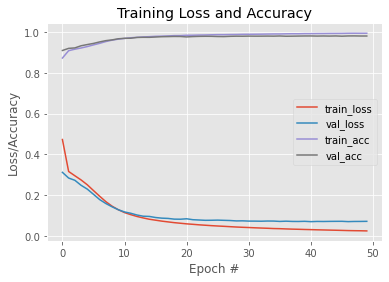

In [8]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(28, 28, 1, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxIt = 50
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 32, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Let's try it with the Adam optimizer.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                250890    
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________
None
[INFO] training network...
Epoch 1/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3578

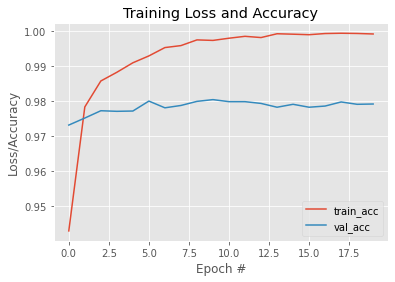

In [9]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(28, 28, 1, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxIt = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 32, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Clearly, even this *tiny* CNN is amazing with MNIST, so let's try it on a harder problem: classifying CIFAR-10

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                327690    
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 328,586
Trainable params: 328,586
Non-trainable params: 0
_________________________________________________________________
None
[INFO] training network...
Epoch 1/20
313/313 [==============================] - 2s 5ms/step - loss: 1.8451 -

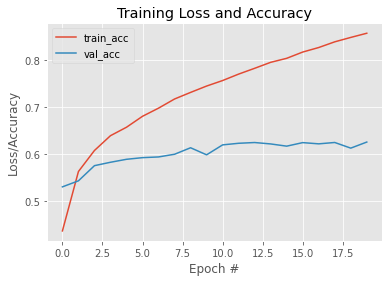

In [10]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(32, 32, 3, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxIt = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))
print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## LeNet

The first CNN that was considered particularly practical is what has become known as LeNet (named after Yann LeCun, who developed it along with his collaborators).

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

class LeNet:
    # create the architecture
    def build(height, width, depth, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(64, (5, 5), padding= 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer
        model.add(Conv2D(128, (5, 5), padding = 'same'))
        model.add(Activation('relu'))
        
        # add a fully-connected layer
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the constructed model
        return model

### LeNet for Classifying MNIST

Let's run the model on MNIST.

[INFO] training network...
Epoch 1/100
375/375 [==============================] - 5s 6ms/step - loss: 0.4128 - accuracy: 0.8714 - val_loss: 0.0506 - val_accuracy: 0.9858
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0403 - accuracy: 0.9879 - val_loss: 0.0349 - val_accuracy: 0.9899
Epoch 3/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0269 - accuracy: 0.9916 - val_loss: 0.0376 - val_accuracy: 0.9896
Epoch 4/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 0.0372 - val_accuracy: 0.9892
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0122 - accuracy: 0.9962 - val_loss: 0.0311 - val_accuracy: 0.9910
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0146 - accuracy: 0.9952 - val_loss: 0.0387 - val_accuracy: 0.9887
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 0.

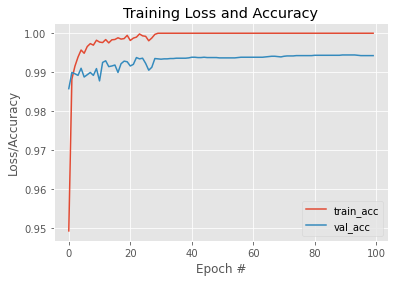

In [12]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNet.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)
print(model.summary())

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### LeNet for Classifying CIFAR-10

[INFO] training network...
Epoch 1/20
313/313 [==============================] - 7s 14ms/step - loss: 1.8620 - accuracy: 0.3181 - val_loss: 1.3192 - val_accuracy: 0.5223
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 1.2298 - accuracy: 0.5599 - val_loss: 1.0550 - val_accuracy: 0.6323
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 0.9698 - accuracy: 0.6572 - val_loss: 0.9392 - val_accuracy: 0.6732
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 0.7976 - accuracy: 0.7195 - val_loss: 0.8884 - val_accuracy: 0.6940
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6515 - accuracy: 0.7716 - val_loss: 0.8328 - val_accuracy: 0.7138
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5319 - accuracy: 0.8135 - val_loss: 0.8649 - val_accuracy: 0.7085
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 0.3978 - accuracy: 0.8583 - val_loss: 0.8660 -

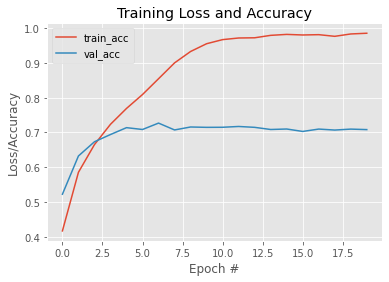

In [13]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNet.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)
print(model.summary())

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Regularized LeNet

Let's add some regularization to the LeNet and see if it helps the overfitting we see with CIFAR-10.

In [14]:
tf.keras.backend.clear_session()
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

class LeNetReg:
    # create the architecture
    def build(height, width, depth, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(64, (5, 5), padding= 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer
        model.add(Conv2D(128, (5, 5), padding = 'same'))
        model.add(Activation('relu'))
        
        # add a fully-connected layer
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        model.add(Dropout(0.5))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the constructed model
        return model

Let's run it on MNIST to see if we can improve our (incredible) 99.4% accuracy!

[INFO] training network...
Epoch 1/100
375/375 [==============================] - 2s 4ms/step - loss: 0.4267 - accuracy: 0.8592 - val_loss: 0.0478 - val_accuracy: 0.9859
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0502 - accuracy: 0.9850 - val_loss: 0.0348 - val_accuracy: 0.9901
Epoch 3/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0315 - accuracy: 0.9904 - val_loss: 0.0322 - val_accuracy: 0.9915
Epoch 4/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0211 - accuracy: 0.9936 - val_loss: 0.0439 - val_accuracy: 0.9887
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0183 - accuracy: 0.9943 - val_loss: 0.0335 - val_accuracy: 0.9907
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 0.0322 - val_accuracy: 0.9916
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0113 - accuracy: 0.9960 - val_loss: 0.

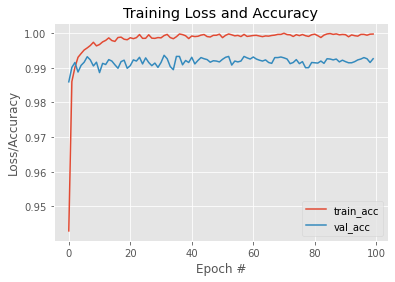

In [15]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

This is slightly worse, but note the noise in the graphs coming from the extra randomness we added with dropout. This is usually a good thing because it means we were likely searching the parameter space more widely.

Let's try it with CIFAR-10.

[INFO] training network...
Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 1.8841 - accuracy: 0.3011 - val_loss: 1.3218 - val_accuracy: 0.5193
Epoch 2/100
313/313 [==============================] - 1s 4ms/step - loss: 1.2455 - accuracy: 0.5563 - val_loss: 1.0819 - val_accuracy: 0.6170
Epoch 3/100
313/313 [==============================] - 1s 4ms/step - loss: 1.0089 - accuracy: 0.6485 - val_loss: 1.0145 - val_accuracy: 0.6317
Epoch 4/100
313/313 [==============================] - 1s 4ms/step - loss: 0.8628 - accuracy: 0.6944 - val_loss: 0.8395 - val_accuracy: 0.7089
Epoch 5/100
313/313 [==============================] - 1s 4ms/step - loss: 0.7486 - accuracy: 0.7376 - val_loss: 0.8221 - val_accuracy: 0.7186
Epoch 6/100
313/313 [==============================] - 1s 4ms/step - loss: 0.6554 - accuracy: 0.7702 - val_loss: 0.8167 - val_accuracy: 0.7197
Epoch 7/100
313/313 [==============================] - 1s 4ms/step - loss: 0.5487 - accuracy: 0.8071 - val_loss: 0.

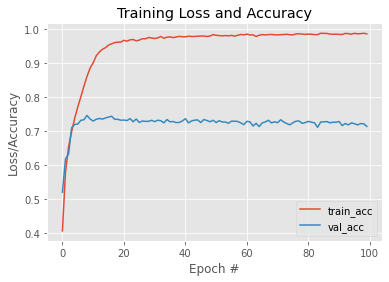

In [16]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Let's go back to SGD and see how it compares.

[INFO] training network...
Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 2.2563 - accuracy: 0.1469 - val_loss: 2.0548 - val_accuracy: 0.2433
Epoch 2/100
313/313 [==============================] - 1s 4ms/step - loss: 1.9960 - accuracy: 0.2775 - val_loss: 2.0987 - val_accuracy: 0.2718
Epoch 3/100
313/313 [==============================] - 1s 4ms/step - loss: 1.8378 - accuracy: 0.3389 - val_loss: 1.6939 - val_accuracy: 0.4025
Epoch 4/100
313/313 [==============================] - 1s 4ms/step - loss: 1.6969 - accuracy: 0.3948 - val_loss: 1.5769 - val_accuracy: 0.4354
Epoch 5/100
313/313 [==============================] - 1s 4ms/step - loss: 1.6045 - accuracy: 0.4257 - val_loss: 1.5214 - val_accuracy: 0.4488
Epoch 6/100
313/313 [==============================] - 1s 4ms/step - loss: 1.5322 - accuracy: 0.4486 - val_loss: 1.5497 - val_accuracy: 0.4536
Epoch 7/100
313/313 [==============================] - 1s 4ms/step - loss: 1.4799 - accuracy: 0.4694 - val_loss: 1.

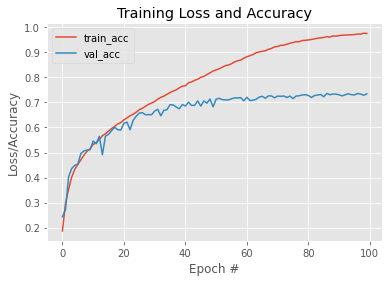

In [17]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We got similar results with SGD.

Some next steps might be to try L1 or L2 regularization.

## AlexNet

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [19]:
class AlexNet:
    def build(height, width, depth, classes, lambda2 = 0.0002):
        model = Sequential(name = 'AlexNet')
        
        model.add(Conv2D(96, (11, 11), strides = (4, 4), input_shape = (height, width, depth),
                         padding='same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, (5, 5), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(256, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(4096, kernel_regularizer = l2(lambda2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes, kernel_regularizer = l2(lambda2)))
        model.add(Activation('softmax'))
        
        return model

In [20]:
tf.keras.backend.clear_session()

from tensorflow.keras.optimizers import Adam

model = AlexNet.build(227, 227, 3, 1000)
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

print(model.summary())

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 57, 57, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 57, 57, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0   

## MiniVGGNet

In [21]:
class MiniVGGNet:
    def build(height, width, depth, classes):
        model = Sequential(name = 'MiniVGGNet')
        
        model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

Model: "MiniVGGNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

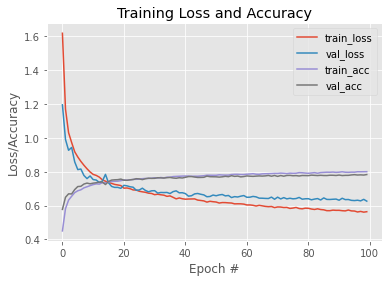

In [22]:
tf.keras.backend.clear_session()

((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = MiniVGGNet.build(32, 32, 3, 10)
opt = SGD(lr = 0.01, decay = 0.1 / 40, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

print(model.summary())

print("[INFO] training network...")
maxIt = 100
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 64, epochs = maxIt, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## VGGNet16 and VGGNet19

These nets can be expensive to run, but let's write classes for them.

In [23]:
class VGGNet16:
    def build(height, width, depth, classes):
        model = Sequential(name = 'VGGNet16')
        
        # conv 1
        model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 2
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 3
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 4
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 5
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 6
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 7
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 8
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 9
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 10
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 11
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 12
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 13
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        # fc 14
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 15
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 16
        model.add(Dense(1000))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the model
        return model

In [24]:
class VGGNet19:
    def build(height, width, depth, classes):
        model = Sequential(name = 'VGGNet19')
        
        # conv 1
        model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 2
        model.add(Conv2D(64, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 3
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 4
        model.add(Conv2D(128, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 5
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 6
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 7
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 8
        model.add(Conv2D(256, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 9
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 10
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 11
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 12
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        # conv 13
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 14
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 15
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # conv 16
        model.add(Conv2D(512, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        # pool
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        # fc 17
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 18
        model.add(Dense(4096))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 19
        model.add(Dense(1000))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the model
        return model

In [25]:
tf.keras.backend.clear_session()

model = VGGNet16.build(224, 224, 3, 1000)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])

print(model.summary())

Model: "VGGNet16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0  

In [26]:
tf.keras.backend.clear_session()

model = VGGNet19.build(224, 224, 3, 1000)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])

print(model.summary())

Model: "VGGNet19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0  